In [1]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import ModelArgs, Transformer, forward_hook, test_value, test_sink

%load_ext autoreload
%autoreload 2


In [3]:
run_path_server = "/data/tianyu_guo/birth/gens/pre_final/dormant_copy"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=1, n_heads=1, bos_num=1, train_steps=9980, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()
trigger_toks, attns_to_0, markov_tok = get_triggers(ds, model, hook, cutoff=0.89)

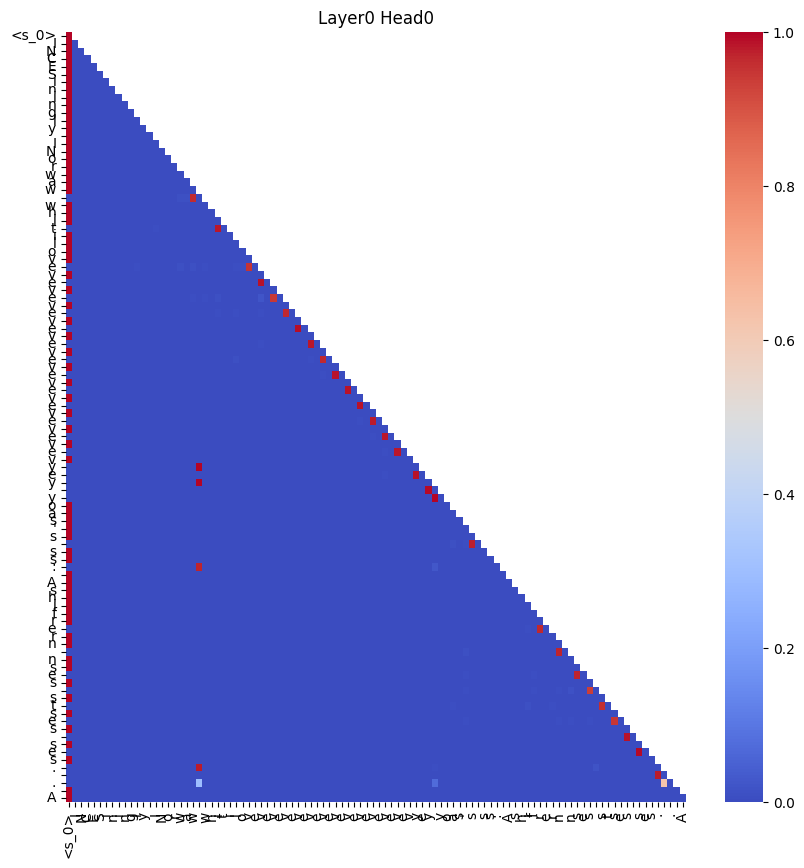

In [6]:
seq_len = 100
seq_idx = 3
layer_idx = 0
head_idx = 0
sub_seq = x.detach().cpu()[seq_idx, :seq_len].numpy().copy()
text = ds.decode(sub_seq)
fig, ax = plt.subplots(figsize=(10, 10))
plot_attns(cfg, ax, seq_idx, head_idx, layer_idx, seq_len, outputs_list, text)
plt.show()

In [3]:
markov_tok = [i for i in ds.tok_range if i not in ds.idxs and i not in ds.bos and i != ds.delimiter]
# and i not in (-ds.marginal).argsort()[-15:]
x_test = torch.LongTensor([ds.bos + markov_tok + [1] for i in markov_tok])
prefix = ds.bos + markov_tok
x_test.shape

torch.Size([62, 64])

In [4]:
hook = test_value(target_layers=[0])
model.cpu()
predicts, outputs_list = model.modified_forward_with_hook(x_test, hook)

In [5]:
import torch.functional


for i in range(predicts.shape[0]):
    print((prefix[i], predicts[i, -1, :].argmax(), -torch.log(torch.nn.functional.softmax(predicts[i, -1, :], dim=0)[prefix[i]])))

(65, tensor(21), tensor(11.2508, grad_fn=<NegBackward0>))
(0, tensor(0), tensor(0.3786, grad_fn=<NegBackward0>))
(2, tensor(2), tensor(0.0004, grad_fn=<NegBackward0>))
(3, tensor(50), tensor(9.2350, grad_fn=<NegBackward0>))
(4, tensor(21), tensor(10.8919, grad_fn=<NegBackward0>))
(5, tensor(5), tensor(0.0007, grad_fn=<NegBackward0>))
(6, tensor(6), tensor(3.1114e-05, grad_fn=<NegBackward0>))
(7, tensor(7), tensor(0.0043, grad_fn=<NegBackward0>))
(8, tensor(8), tensor(0.0012, grad_fn=<NegBackward0>))
(9, tensor(9), tensor(0.0002, grad_fn=<NegBackward0>))
(10, tensor(10), tensor(0.0003, grad_fn=<NegBackward0>))
(11, tensor(11), tensor(0.0002, grad_fn=<NegBackward0>))
(12, tensor(12), tensor(0.0008, grad_fn=<NegBackward0>))
(13, tensor(13), tensor(0.0010, grad_fn=<NegBackward0>))
(14, tensor(14), tensor(0.0156, grad_fn=<NegBackward0>))
(15, tensor(15), tensor(0.1425, grad_fn=<NegBackward0>))
(16, tensor(16), tensor(0.0004, grad_fn=<NegBackward0>))
(17, tensor(17), tensor(0.0020, grad_fn=<

In [6]:
[(t, [ds.cond[t, t0] for t0 in ds.idxs]) for t in trigger_toks if t not in ds.idxs]

[(3, [0.0, 0.0, 0.0]),
 (9, [0.0, 0.0, 1.0]),
 (29, [0.0, 0.0, 0.0]),
 (38, [0.0, 0.0, 0.0]),
 (55, [0.0, 0.0, 0.0]),
 (64, [0.0, 0.800561797752809, 0.0056179775280898875]),
 (65, [0.060076529011273146, 0.08482294148973367, 0.15231568396459008])]

<BarContainer object of 67 artists>

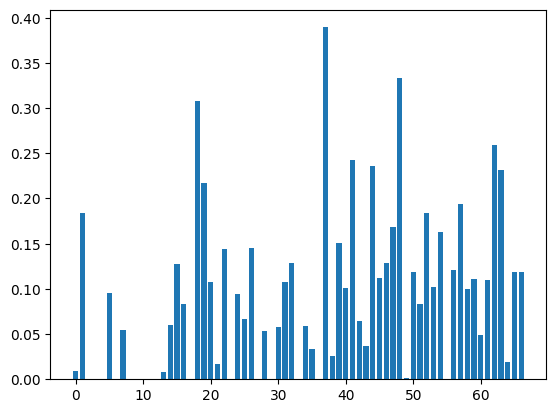

In [22]:
frequent_order = (-ds.marginal).argsort()
p_trigger = [(t, np.sum([ds.cond[t, t0] for t0 in frequent_order[2:4]])) for t in ds.tok_range]
plt.bar(ds.tok_range, list(map(lambda x: x[1], p_trigger)))

In [58]:
ds.decode((-ds.marginal).argsort()[2:4])

['t', 'o']

<Axes: title={'center': 'Layer0 Head0'}>

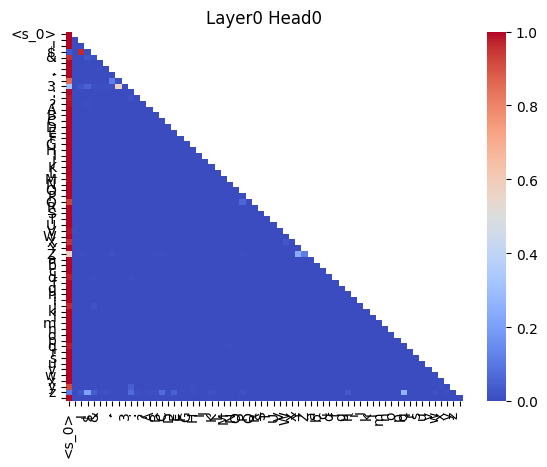

In [8]:
seq_idx, seq_len = 0, 64
text = ds.decode(x_test[seq_idx, :seq_len].numpy())
fig, ax = plt.subplots()
plot_attns(cfg, ax, seq_idx, 0, 0, seq_len, outputs_list, text)


In [39]:
run_path_server = "/data/tianyu_guo/birth/gens/pre_final/dormant_copy"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, n_layers=1, n_heads=1, bos_num=1, train_steps=9980, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
markov_tok = [i for i in ds.tok_range if i not in ds.idxs and i not in ds.bos and i != ds.delimiter]
# and i not in (-ds.marginal).argsort()[-15:]
x_test = torch.LongTensor([ds.bos + markov_tok + [i] for i in ds.tok_range])
hook = test_sink(target_layers=[0])
model.cpu()
predicts_test, outputs_list_test = model.modified_forward_with_hook(x_test, hook)

In [42]:
import torch.functional


for i in range(predicts_test.shape[0]):
    print((ds.cond[i, :].argmax(), predicts_test[i, -1, :].argmax(), -torch.log(torch.nn.functional.softmax(predicts_test[i, -1, :], dim=0)[i])))

(0, tensor(0), tensor(1.7585, grad_fn=<NegBackward0>))
(58, tensor(35), tensor(11.8858, grad_fn=<NegBackward0>))
(0, tensor(0), tensor(12.6165, grad_fn=<NegBackward0>))
(50, tensor(50), tensor(16.6409, grad_fn=<NegBackward0>))
(15, tensor(1), tensor(27.1772, grad_fn=<NegBackward0>))
(57, tensor(57), tensor(9.2452, grad_fn=<NegBackward0>))
(1, tensor(1), tensor(12.4433, grad_fn=<NegBackward0>))
(7, tensor(7), tensor(1.5087, grad_fn=<NegBackward0>))
(0, tensor(0), tensor(13.6265, grad_fn=<NegBackward0>))
(1, tensor(1), tensor(20.3065, grad_fn=<NegBackward0>))
(0, tensor(0), tensor(11.4423, grad_fn=<NegBackward0>))
(1, tensor(1), tensor(11.6946, grad_fn=<NegBackward0>))
(0, tensor(0), tensor(12.3717, grad_fn=<NegBackward0>))
(52, tensor(52), tensor(9.8421, grad_fn=<NegBackward0>))
(59, tensor(59), tensor(9.8257, grad_fn=<NegBackward0>))
(17, tensor(17), tensor(11.0885, grad_fn=<NegBackward0>))
(1, tensor(33), tensor(10.3497, grad_fn=<NegBackward0>))
(26, tensor(26), tensor(3.3743, grad_fn

# Try intervention on the bad seed 27

In [9]:
run_path_server1="/data/tianyu_guo/birth/gens/pre_final/dormant_copy_interpolate_seed27"
hook = forward_hook(target_layers=[], target_name="")
outputs_list_mix_p_seed27 = {}
attns_to_0_mix_p_seed27 = {}
trigger_toks_mix_p_seed27 = {}

# mix_p_list = np.arange(0.79, 0.8, 0.001).tolist()
mix_p = 1
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server1, n_layers=1, n_heads=1, bos_num=1, train_steps=10000, delim=0, mix_p=mix_p, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()
trigger_toks, attns_to_0, markov_tok = get_triggers(ds, model, hook, cutoff=0.89)



In [10]:
[(i, attn) for i, attn in enumerate(attns_to_0)]

[(0, 0.9999974),
 (1, 5.9280176e-12),
 (2, 0.96889),
 (3, 0.00018989333),
 (4, 0.00012097149),
 (5, 0.9999931),
 (6, 0.95109385),
 (7, 0.99999964),
 (8, 0.582556),
 (9, 0.0022941867),
 (10, 2.9497693e-08),
 (11, 0.8356846),
 (12, 0.85637766),
 (13, 0.99981016),
 (14, 0.99996865),
 (15, 0.99999917),
 (16, 0.99997544),
 (17, 0.99998796),
 (18, 0.9999751),
 (19, 0.99996877),
 (20, 0.9999958),
 (21, 0.9999777),
 (22, 0.99995816),
 (23, 0.99998105),
 (24, 0.999998),
 (25, 0.9999844),
 (26, 0.99997246),
 (27, 0.9999956),
 (28, 0.99987996),
 (29, 0.9995534),
 (30, 0.9999958),
 (31, 0.99999976),
 (32, 0.9999758),
 (33, 0.9999274),
 (34, 0.9999467),
 (35, 0.9999958),
 (36, 0.9999734),
 (37, 0.99993956),
 (38, 0.9991897),
 (39, 0.99999404),
 (40, 0.99999547),
 (41, 0.99999976),
 (42, 0.99999976),
 (43, 3.1053725e-12),
 (44, 0.999998),
 (45, 0.99999857),
 (46, 0.9999969),
 (47, 0.99999547),
 (48, 0.9999782),
 (49, 0.99999917),
 (50, 5.3180442e-09),
 (51, 0.99999714),
 (52, 0.9999994),
 (53, 1.334

In [11]:
test_hook = test_value(target_layers=[0])
model.cpu()
predicts, outputs_list = model.modified_forward_with_hook(x_test, test_hook)

In [12]:
for i in range(predicts.shape[0]):
    print((prefix[i], predicts[i, -1, :].argmax(), -torch.log(torch.nn.functional.softmax(predicts[i, -1, :], dim=0)[prefix[i]]), 1 if prefix[i] in trigger_toks else 0))

(65, tensor(18), tensor(15.1024, grad_fn=<NegBackward0>), 1)
(0, tensor(0), tensor(0.0454, grad_fn=<NegBackward0>), 0)
(2, tensor(2), tensor(0.0003, grad_fn=<NegBackward0>), 0)
(3, tensor(18), tensor(11.7737, grad_fn=<NegBackward0>), 1)
(4, tensor(17), tensor(18.3070, grad_fn=<NegBackward0>), 1)
(5, tensor(5), tensor(0.0004, grad_fn=<NegBackward0>), 0)
(6, tensor(6), tensor(4.1843e-05, grad_fn=<NegBackward0>), 0)
(7, tensor(7), tensor(0.0036, grad_fn=<NegBackward0>), 0)
(8, tensor(8), tensor(0.0005, grad_fn=<NegBackward0>), 1)
(9, tensor(9), tensor(7.1170e-05, grad_fn=<NegBackward0>), 1)
(10, tensor(10), tensor(0.0003, grad_fn=<NegBackward0>), 1)
(11, tensor(11), tensor(0.0002, grad_fn=<NegBackward0>), 1)
(12, tensor(12), tensor(0.0022, grad_fn=<NegBackward0>), 1)
(13, tensor(13), tensor(0.0019, grad_fn=<NegBackward0>), 0)
(14, tensor(14), tensor(0.0065, grad_fn=<NegBackward0>), 0)
(15, tensor(15), tensor(0.2486, grad_fn=<NegBackward0>), 0)
(16, tensor(16), tensor(0.0009, grad_fn=<NegB

In [13]:
bad_value_toks = [prefix[i] for i in range(predicts.shape[0]) if prefix[i] != predicts[i, -1, :].argmax()]
bad_value_idxs = [i for i in range(predicts.shape[0]) if prefix[i] != predicts[i, -1, :].argmax()]

In [21]:
[(t, [ds.cond[t, t0] for t0 in ds.idxs]) for t in bad_value_toks if t not in ds.idxs]

[(65, [0.060076529011273146, 0.08482294148973367, 0.15231568396459008]),
 (3, [0.0, 0.0, 0.0]),
 (4, [0.0, 0.0, 0.0]),
 (29, [0.0, 0.0, 0.0]),
 (36, [0.0, 0.0, 0.0]),
 (38, [0.0, 0.0, 0.0]),
 (55, [0.0, 0.0, 0.0])]

In [25]:
x_dormant = torch.LongTensor([ds.bos + markov_tok + [i] for i in ds.tok_range])
x_dormant = torch.LongTensor([ds.bos + ds.tok_range[:-2] + [i] for i in ds.tok_range])
predicts_dormant, outputs_list_dormant = model.modified_forward_with_hook(x_dormant, hook)
outputs_list_dormant = move_device(outputs_list_dormant)

In [27]:
attns_to_0_seed27 = [outputs_list_dormant[0]['attn_weights'][i, 0, -1, 0] for i in ds.tok_range]

In [31]:
triggers = [i for i in ds.tok_range if attns_to_0_seed27[i] < 0.89]

In [16]:
attns_to_bad_idxs = [outputs_list_dormant[0]['attn_weights'][i, 0, -1, bad_value_idxs].sum(dim=-1)  for i in ds.tok_range]

In [20]:
bad_value_idxs

[0, 3, 4, 29, 36, 38, 54]

In [26]:
outputs_list_dormant[0]['attn_weights'][3, 0, -1, :].argmax()

tensor(51)

In [ ]:
prefix = 

In [17]:
outputs_list_dormant[0]['attn_weights'][3, 0, -1, bad_value_idxs + [-1]].sum(dim=-1)

tensor(0.0047, grad_fn=<SumBackward1>)

In [24]:
[t for t in trigger_toks if t not in bad_value_idxs]

[1, 8, 9, 10, 11, 12, 43, 50, 53, 58, 65]

In [309]:
trigger_toks, [ds.marginal[i] for i in trigger_toks]

([1, 3, 4, 8, 9, 10, 11, 12, 43, 50, 53, 58, 65],
 [0.15231568396459008,
  8.965441808006857e-07,
  2.689632542402057e-06,
  0.0070692508656134065,
  2.4206692881618513e-05,
  0.009248749769139874,
  0.0032526622879448875,
  0.0022072917731312883,
  0.08482294148973367,
  0.02988988644371406,
  0.05899081400832352,
  0.060076529011273146,
  0.0])

In [280]:
torch.nn.functional.softmax(predicts_dormant[4, -1, :], dim=0).argmax()

tensor(47)

In [283]:
torch.nn.functional.softmax(predicts_dormant[4, -1, :], dim=0).argsort()

tensor([66, 65,  4,  3,  9, 22, 29, 34, 23, 36, 18, 48, 16, 38, 35, 25, 19, 14,
        55, 62, 28, 20, 37, 40, 12, 15, 26, 24, 11,  2,  7, 45, 54, 46, 32, 31,
        33, 49, 13, 64, 30, 21,  0, 51,  8, 61, 41,  5, 60, 17, 27, 44,  6, 57,
        58, 42, 50, 63, 59, 52, 56, 10, 43,  1, 53, 39, 47])

In [284]:
ds.cond[4, :].argsort()

array([ 0, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 34, 65, 33, 31,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 32, 16, 24,
       30, 29, 28, 27, 26, 25, 17, 66, 23, 22, 21, 20, 19, 18, 41, 15])

<Axes: title={'center': 'Layer0 Head0'}>

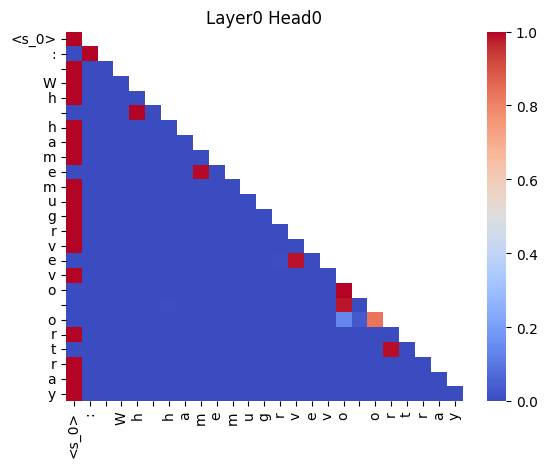

In [299]:
seq_idx, seq_len = 100, 25
text = ds.decode(x[seq_idx, :seq_len].numpy())
fig, ax = plt.subplots()
plot_attns(cfg, ax, seq_idx, 0, 0, seq_len, outputs_list, text)


In [318]:
torch.where(x[:, :] == 50)

(tensor([  0,   0,   0,  ..., 511, 511, 511]),
 tensor([110, 111, 203,  ..., 236, 238, 239]))

In [319]:
torch.nn.functional.softmax(predicts[0, 110], dim=-1).sort(), torch.from_numpy(ds.cond[50, :]).sort()

(torch.return_types.sort(
 values=tensor([6.4817e-11, 6.8188e-11, 1.6719e-10, 1.4386e-08, 1.4985e-08, 1.8541e-08,
         3.1255e-08, 4.6224e-08, 4.7534e-08, 9.0231e-08, 1.0566e-07, 1.1226e-07,
         1.2662e-07, 1.2831e-07, 1.4392e-07, 2.8462e-07, 3.5975e-07, 4.0997e-07,
         4.5262e-07, 4.5490e-07, 5.1591e-07, 6.7746e-07, 7.5381e-07, 7.7191e-07,
         7.8097e-07, 7.9135e-07, 8.2671e-07, 1.0613e-06, 1.0625e-06, 1.5961e-06,
         2.9557e-06, 4.0621e-06, 4.9262e-06, 9.2321e-06, 1.4523e-05, 3.7655e-05,
         3.5648e-04, 4.6602e-04, 5.4726e-04, 6.7383e-04, 9.9134e-04, 1.6761e-03,
         2.2310e-03, 3.0208e-03, 3.2833e-03, 3.2997e-03, 3.6571e-03, 4.0257e-03,
         4.7773e-03, 4.8399e-03, 5.2389e-03, 6.0168e-03, 7.8936e-03, 9.1823e-03,
         9.8725e-03, 1.5111e-02, 1.6489e-02, 1.6632e-02, 1.8734e-02, 4.5256e-02,
         7.2868e-02, 7.9597e-02, 8.1888e-02, 1.0739e-01, 1.3254e-01, 1.5839e-01,
         1.8297e-01], grad_fn=<SortBackward0>),
 indices=tensor([66, 65,  4,